In [3]:
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import tqdm
import torch
import os

In [4]:
train_dataset_path = r'/home/shubham/CODES/PlayGround/MNIST_Dataset/trainingSet/train'
val_dataset_path = r'/home/shubham/CODES/PlayGround/MNIST_Dataset/trainingSet/validation'
test_dataset_path = r'/home/shubham/CODES/PlayGround/MNIST_Dataset/testSet'

In [8]:
def get_mean_std(dataset_path):
    mean = 0
    std = 0
    total_image_count = 0
    dataset_transform=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    dataset_folder=torchvision.datasets.ImageFolder(root=dataset_path, transform=dataset_transform)
    dataset_loader=torch.utils.data.DataLoader(dataset=dataset_folder, batch_size=32, shuffle=False)
    for images, _ in tqdm.tqdm(dataset_loader):
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_batch
    
    mean /= total_image_count
    std /= total_image_count
    return mean, std

In [9]:
train_mean, train_std=get_mean_std(train_dataset_path)
print("Trainset Mean: ",train_mean)
print("Trainset Standard Deviation: ",train_std)

100%|█████████████████████████████████████████| 921/921 [00:27<00:00, 33.38it/s]

Trainset Mean:  tensor([0.1351, 0.1351, 0.1351])
Trainset Standard Deviation:  tensor([0.2782, 0.2782, 0.2782])


In [5]:
val_mean, val_std=get_mean_std(val_dataset_path)
print("Validation Set Mean: ",val_mean)
print("Validation Set Standard Deviation: ",val_std)

100%|█████████████████████████████████████████| 393/393 [00:11<00:00, 33.51it/s]

Validation Set Mean:  tensor([0.1352, 0.1352, 0.1352])
Validation Set Standard Deviation:  tensor([0.2783, 0.2783, 0.2783])


In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(train_mean), torch.Tensor(train_std))
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(val_mean), torch.Tensor(val_std))
])

In [7]:
train_dataset=torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)
val_dataset=torchvision.datasets.ImageFolder(root=val_dataset_path, transform=val_transforms)

In [8]:
def show_transformed_images(transformed_dataset):
    loader=torch.utils.data.DataLoader(transformed_dataset, batch_size=6, shuffle=True)
    batch=next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([3, 4, 2, 3, 2, 3])


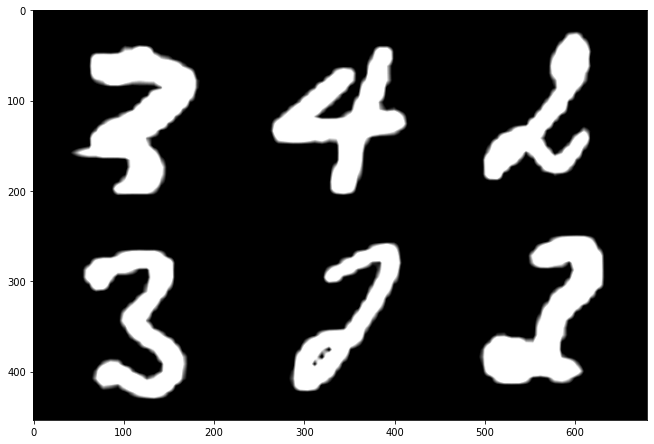

In [9]:
show_transformed_images(train_dataset)

In [10]:
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [12]:
def train_nn(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    device=set_device()
    for epoch in range(n_epochs):
        print("Epoch number %d " %(epoch + 1))
        model.train()
        running_loss=0.0
        running_correct=0.0
        total=0
        
        for data in train_loader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            total+=labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            loss=criterion(outputs,labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss+=loss.item()
            running_correct+=(labels==predicted).sum().item()
            
        epoch_loss=running_loss/len(train_loader)
        epoch_acc = 100.00*running_correct/total
        
        print(" -> Training dataset. Got %d out of %d images correct (%3f%%). Epoch loss: %3f" %(running_correct, total, epoch_acc, epoch+loss))
        evaluate_model_on_validation_set(model, val_loader)
    print("Finished!!")
    return

In [13]:
def evaluate_model_on_validation_set(model, val_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total=0
    device=set_device()
    
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            total+=labels.size(0)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (labels==predicted).sum().item()
    
    epoch_acc = 100.00*predicted_correctly_on_epoch/total
    print(" -> Validation dataset. Got %d out of %d images correct (%3f%%)" %(predicted_correctly_on_epoch, total, epoch_acc))

In [14]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model=models.resnet18(pretrained=False)
num_features=resnet18_model.fc.in_features
num_classes=10
resnet18_model.fc=nn.Linear(num_features, num_classes)
device=set_device()
resnet18_model=resnet18_model.to(device)
loss_fun=nn.CrossEntropyLoss()

optimizer=optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

/home/shubham/tf-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shubham/tf-gpu/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
train_nn(resnet18_model, train_loader, val_loader, loss_fun, optimizer, 10)

Epoch number 1 
 -> Training dataset. Got 27267 out of 29444 images correct (92.606303%). Epoch loss: 0.018338
 -> Validation dataset. Got 28608 out of 29444 images correct (97.160712%)
Epoch number 2 
 -> Training dataset. Got 28962 out of 29444 images correct (98.362994%). Epoch loss: 1.069753
 -> Validation dataset. Got 29199 out of 29444 images correct (99.167912%)
Epoch number 3 
 -> Training dataset. Got 29097 out of 29444 images correct (98.821492%). Epoch loss: 2.290063
 -> Validation dataset. Got 28977 out of 29444 images correct (98.413938%)
Epoch number 4 
 -> Training dataset. Got 29103 out of 29444 images correct (98.841869%). Epoch loss: 3.386847
 -> Validation dataset. Got 28879 out of 29444 images correct (98.081103%)
Epoch number 5 
 -> Training dataset. Got 29097 out of 29444 images correct (98.821492%). Epoch loss: 5.032918
 -> Validation dataset. Got 29079 out of 29444 images correct (98.760359%)
Epoch number 6 
 -> Training dataset. Got 29099 out of 29444 images co

In [16]:
torch.save(resnet18_model,r'/home/shubham/CODES/PlayGround/MNIST_resnet18.pt')

In [36]:
def classify(model, image_transforms, image_path):
    device = set_device()
    model = model.eval()
    image = Image.open(image_path)
    image = image.convert('RGB')
    plt.imshow(image)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    
    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    #plt.title("Prediction :",predicted.item())
    print("Prediction : %d "%(predicted.item()))
    return

Prediction : 2 


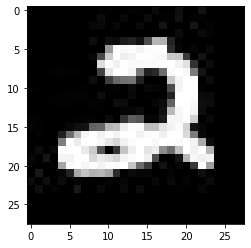

In [37]:
IMAGE_PATH=r'/home/shubham/CODES/PlayGround/MNIST_Dataset/testSet/img_1.jpg'
MODEL_PATH=r'/home/shubham/CODES/PlayGround/MNIST_resnet18.pt'

model = torch.load(MODEL_PATH)

image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

classify(model, image_transforms, IMAGE_PATH)